# Import


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Load and Check Data

## Load Data

In [104]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

## Outlier Detection

In [105]:
features = ['Age', 'SibSp', 'Parch', 'Fare']
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, features)
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [106]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## Joining Train and Test Set

In [107]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Check for Null and Missing Values

In [108]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [109]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [110]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [111]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [112]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical Values

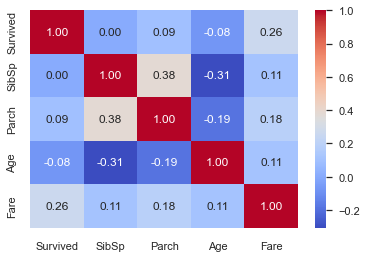

In [113]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

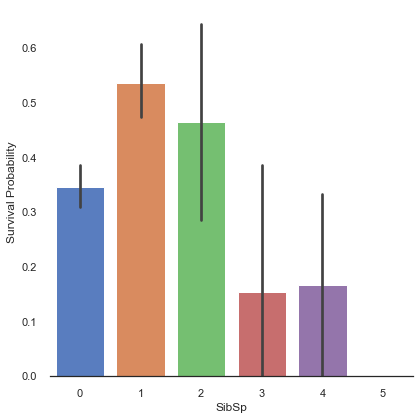

In [114]:
g = sns.factorplot('SibSp', 'Survived', data=train, kind='bar', size=6, palette='muted')
# despine은 y축의 선을 없앨 것인지를 결정한다.
g.despine(left=True)
g.set_ylabels('Survival Probability')

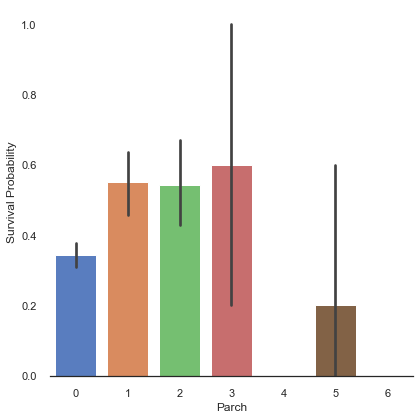

In [115]:
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

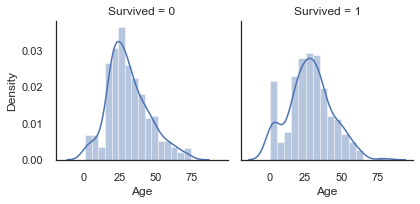

In [116]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

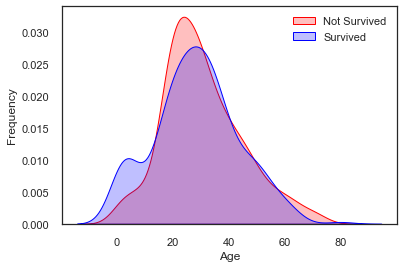

In [117]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not Survived', 'Survived'])

In [118]:
dataset['Fare'].isnull().sum()

1

In [119]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

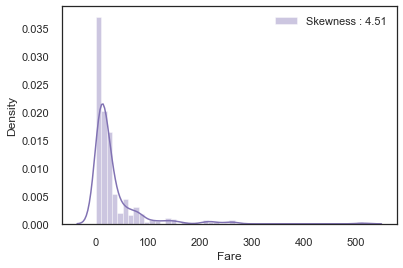

In [120]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

In [121]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

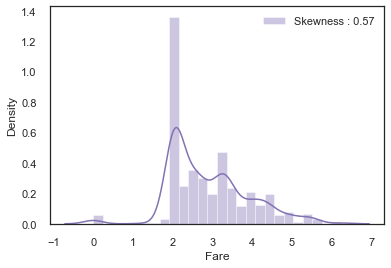

In [122]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

## Categorical Values

Text(0, 0.5, 'Survival Probability')

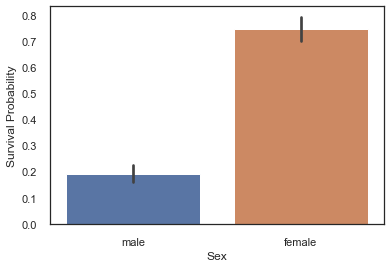

In [123]:
g = sns.barplot('Sex', 'Survived', data=train)
g.set_ylabel('Survival Probability')

In [124]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


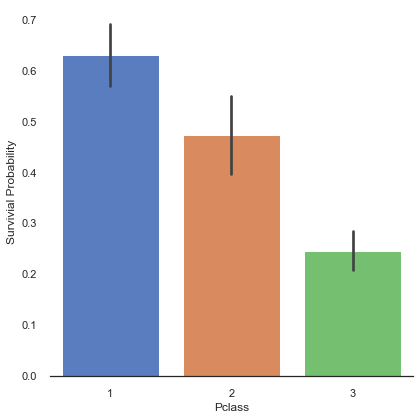

In [125]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survivial Probability')

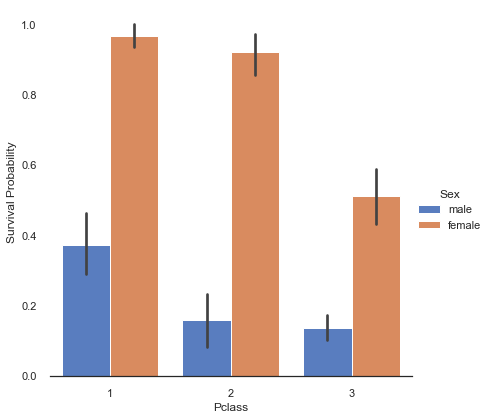

In [126]:
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

In [127]:
dataset['Embarked'].isnull().sum()

2

In [128]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

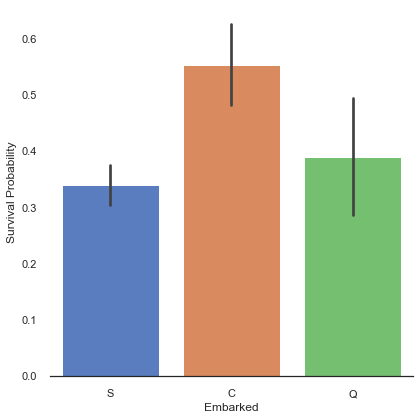

In [129]:
g = sns.factorplot('Embarked', 'Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

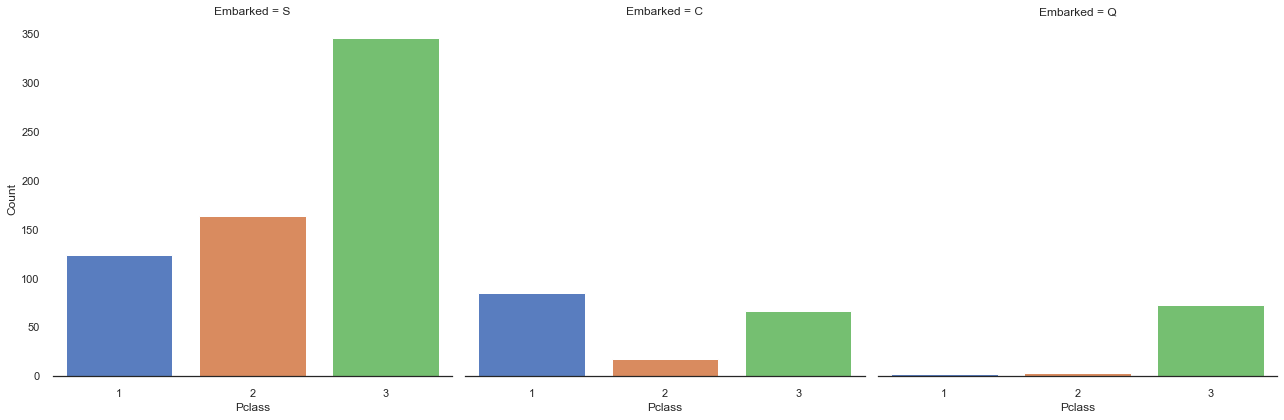

In [130]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g.set_ylabels('Count')

# Filling Missing Values

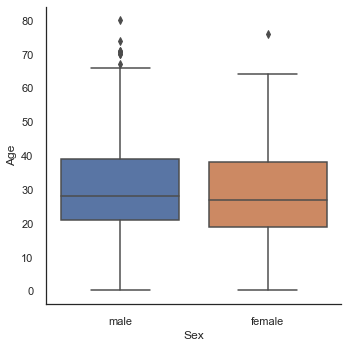

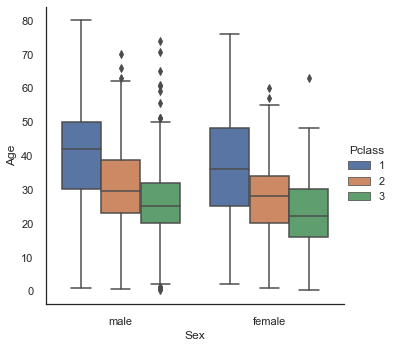

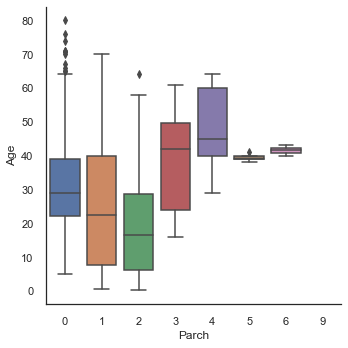

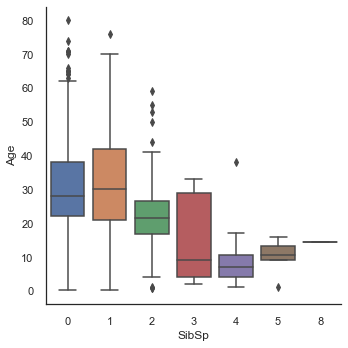

In [131]:
sns.factorplot('Sex', 'Age', data=dataset, kind='box')
sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box')
sns.factorplot('Parch', 'Age', data=dataset, kind='box')
sns.factorplot('SibSp', 'Age', data=dataset, kind='box')

<AxesSubplot:>

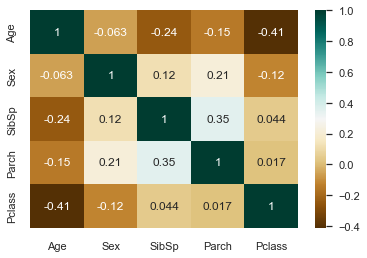

In [132]:
dataset['Sex'] = dataset['Sex'].map({"male": 0, "female": 1})
sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [133]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_med
    else:
        dataset['Age'].iloc[i] = age_pred

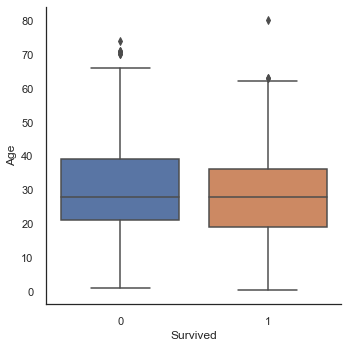

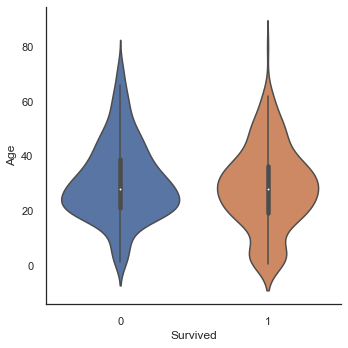

In [134]:
sns.factorplot('Survived', 'Age', data=train, kind='box')
sns.factorplot('Survived', 'Age', data=train, kind='violin')

# Feature Engineering

In [135]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [136]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [137]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

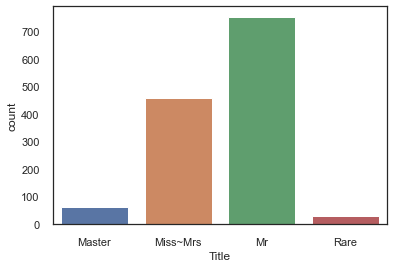

In [138]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])

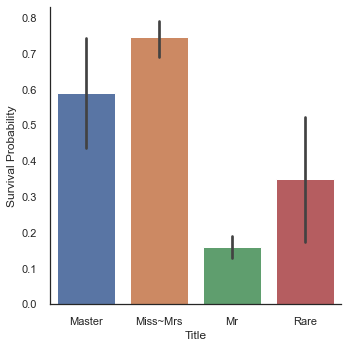

In [139]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

In [140]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

In [141]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

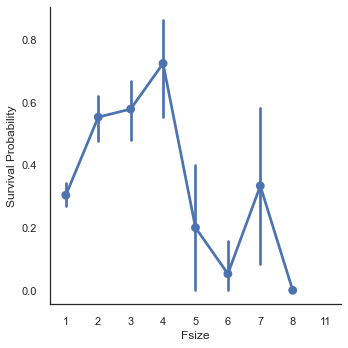

In [142]:
g = sns.factorplot('Fsize', 'Survived', data=dataset)
g.set_ylabels('Survival Probability')

In [143]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

Text(0, 0.5, 'Survival Probability')

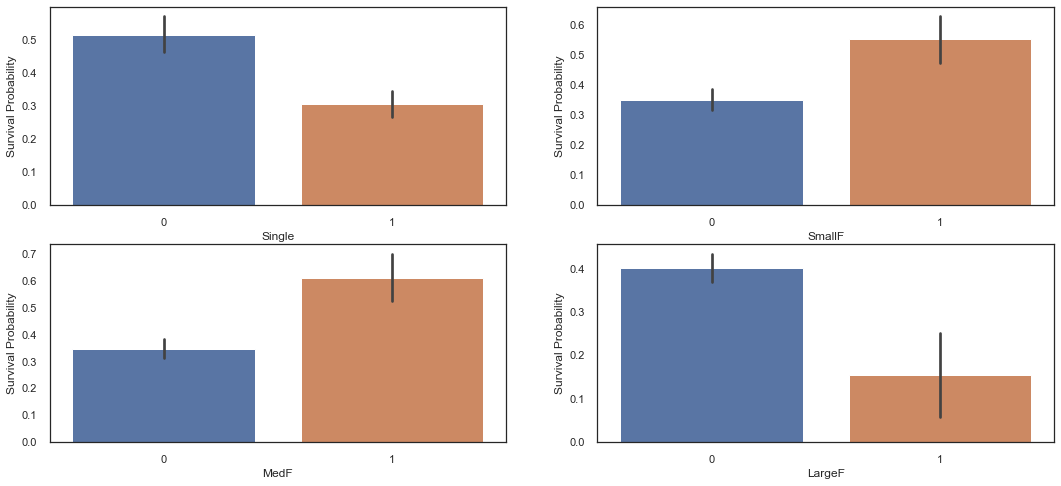

In [144]:
f, ax = plt.subplots(2, 2, figsize=(18, 8))
sns.barplot('Single', 'Survived', data=dataset, ax=ax[0, 0])
ax[0, 0].set_ylabel('Survival Probability')
sns.barplot('SmallF', 'Survived', data=dataset, ax=ax[0, 1])
ax[0, 1].set_ylabel('Survival Probability')
sns.barplot('MedF', 'Survived', data=dataset, ax=ax[1, 0])
ax[1, 0].set_ylabel('Survival Probability')
sns.barplot('LargeF', 'Survived', data=dataset, ax=ax[1, 1])
ax[1, 1].set_ylabel('Survival Probability')

In [145]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [146]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [147]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [148]:
dataset['Cabin'].isnull().sum()

1007

In [149]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [150]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

<AxesSubplot:xlabel='Cabin', ylabel='count'>

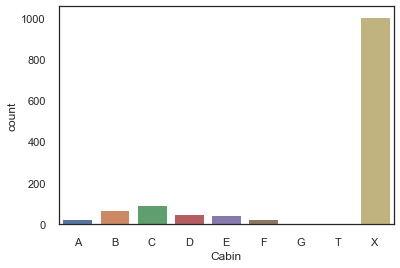

In [151]:
sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

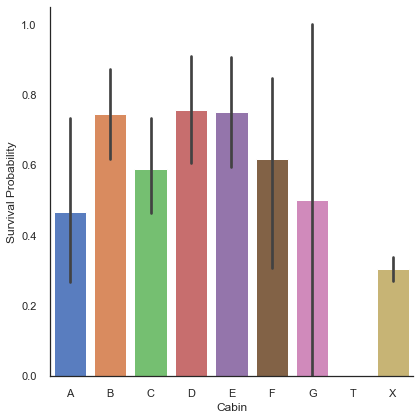

In [152]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar', size=6, palette='muted', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g.set_ylabels('Survival Probability')

In [153]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

In [154]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [155]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [156]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [157]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [158]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [169]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [170]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

## Simple Modeling

### Cross Validate Models

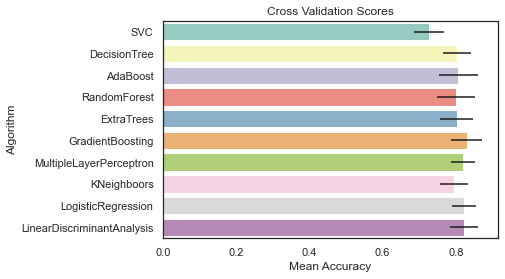

In [60]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

# **kwargs의 의미는 어떤 값을 넣을진 모르는데 변수가 딕셔너리 형태로 입력되는 것, *args는 변수가 튜플 형태로 입력되는 것
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

### Hyperparameter Tuning for Best Models

In [61]:
# AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'],
                 'n_estimators': [1, 2],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
# verbose=0(default)면 메시지 출력 안함, 1이면 간단한 메시지 출력, 2면 하이퍼 파라미터별 메시지 출력
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8275536261491316

In [62]:
# ExtraTrees
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [63]:
# RandomForest
RFC = RandomForestClassifier()
rf_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342951991828397

In [64]:
# GradientBoosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8286133810010214

In [65]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### Plot Learning Curve

<module 'matplotlib.pyplot' from 'C:\\Users\\SeonukKim\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

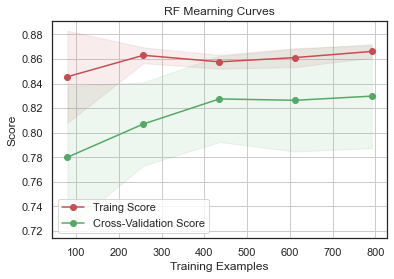

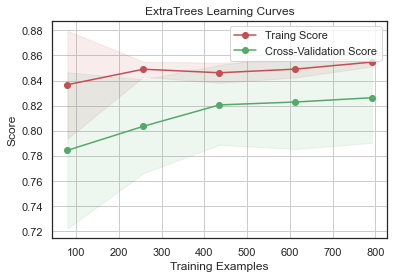

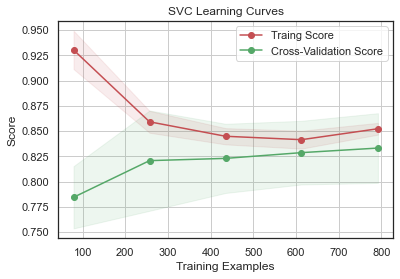

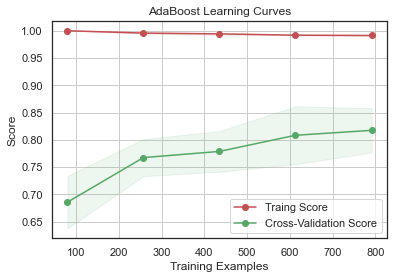

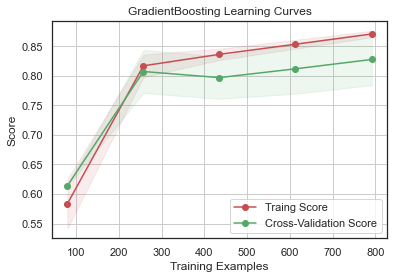

In [66]:
# np.linspace(시작값, 끝값, 갯수) 갯수 안쓰면 50개
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # 그래프에 격자 표시 넣기
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traing Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')
    
    return plt

plot_learning_curve(gsRFC.best_estimator_, 'RF Mearning Curves', X_train, Y_train, cv=kfold)
plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsSVMC.best_estimator_,"SVC Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting Learning Curves", X_train, Y_train, cv=kfold)

### Feature Importance of Tree Based Classifiers

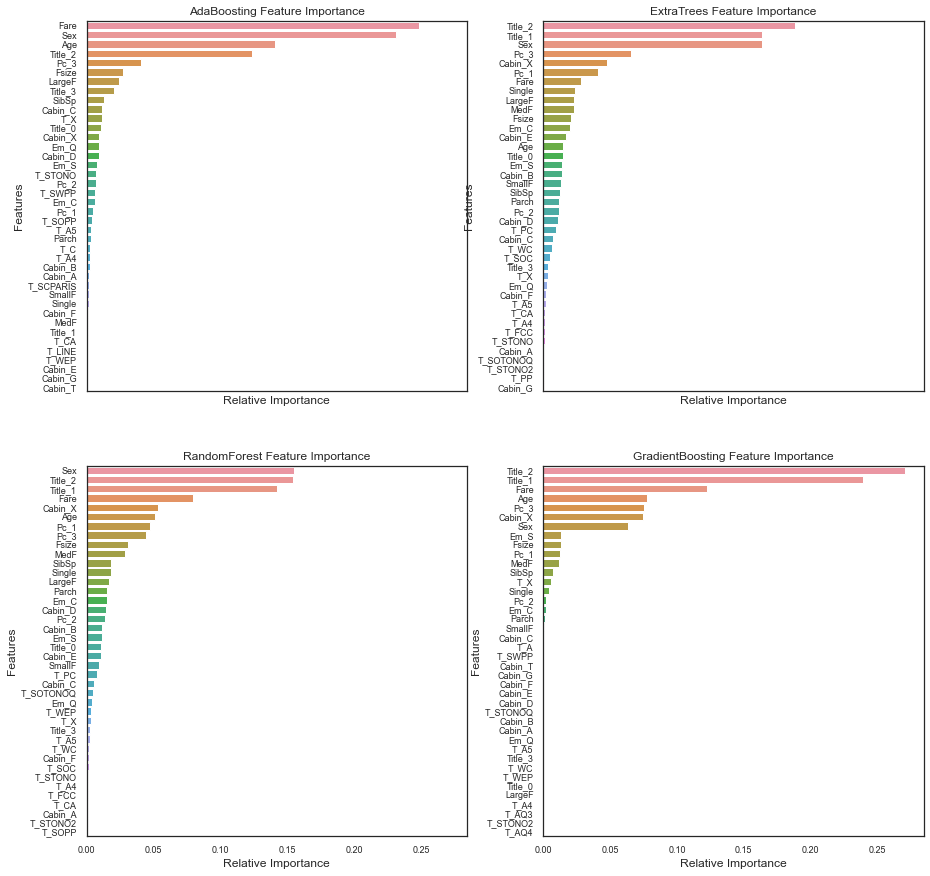

In [67]:
# sharex: 모든 서브플롯이 같은 x축 눈금을 사용하도록 함.
nrows = ncols = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15, 15))
names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
        g.set_xlabel('Relative Importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' Feature Importance')
        nclassifier += 1

<AxesSubplot:>

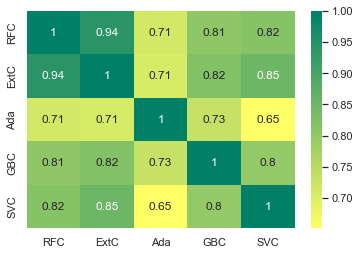

In [68]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)
sns.heatmap(ensemble_results.corr(), annot=True, cmap='summer_r')

## Ensembling Modeling

In [69]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

## Prediction

In [70]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('titanic_with_ensemble_modeling.csv', index=False)

---

# AutoML - Pycaret

In [59]:
import sklearn
sklearn.__version__ # sklearn 버전 확인 #kernel restart 필요

'0.23.2'

In [60]:
!pip install --upgrade --user scipy==1.5.4

In [61]:
!pip install tensorflow==2.7.0

In [62]:
!pip install --upgrade --user scikit-learn==0.23.2

In [63]:
import shap
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import random

random_state=0
np.random.seed(random_state)
random.seed(random_state)

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tensorflow.keras.utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [86]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [64]:
#installing for the first time
!pip install pycaret
#if you have installed beta version in past, run the below code to upgrade
!pip install --upgrade pycaret
#Run the below code in your notebook to check the installed version
from pycaret.utils import version
version()

'2.3.9'

In [65]:
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In [66]:
from pycaret.classification import * # pycaret classification 실행

In [67]:
# check_metric, add_metric을 이용하여 새로운 평가지표 추가 가능
from pycaret.utils import check_metric

In [183]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [69]:
train['Survived'] = train['Survived'].astype(int)
#Y_train = train['Survived']
#X_train = train.drop(labels=['Survived'], axis=1)

In [87]:
train_setup = setup(data=train, target='Survived', train_size=0.9, remove_outliers=True, outliers_threshold=0.05, silent=True)

,Description,Value
0,session_id,813
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(881, 67)"
5,Missing Values,False
6,Numeric Features,58
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [92]:
top_data = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8285,0.8799,0.7278,0.8082,0.7622,0.6290,0.6344,0.0250
ridge,Ridge Classifier,0.8218,0.0000,0.7278,0.7942,0.7557,0.6161,0.6215,0.0050
catboost,CatBoost Classifier,0.8218,0.8773,0.7244,0.7974,0.7553,0.6160,0.6214,0.4790
lightgbm,Light Gradient Boosting Machine,0.8191,0.8699,0.7346,0.7852,0.7531,0.6113,0.6173,0.0550
lr,Logistic Regression,0.8178,0.8751,0.7349,0.7797,0.7531,0.6093,0.6134,0.0190
lda,Linear Discriminant Analysis,0.8152,0.8767,0.7244,0.7790,0.7478,0.6025,0.6066,0.0060
xgboost,Extreme Gradient Boosting,0.8152,0.8698,0.7313,0.7771,0.7475,0.6027,0.6086,0.0750
rf,Random Forest Classifier,0.8045,0.8681,0.7176,0.7674,0.7365,0.5818,0.5874,0.0790
ada,Ada Boost Classifier,0.8019,0.8519,0.7419,0.7440,0.7397,0.5802,0.5833,0.0230
dt,Decision Tree Classifier,0.7991,0.7910,0.7278,0.7430,0.7333,0.5725,0.5745,0.0040


In [93]:
evaluate_model(top_data)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [97]:
blend_weight = blend_models(compare_models(n_select = 3), weights = [0.4,0.3,0.3], verbose = False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8285,0.8799,0.7278,0.8082,0.7622,0.6290,0.6344,0.0220
ridge,Ridge Classifier,0.8218,0.0000,0.7278,0.7942,0.7557,0.6161,0.6215,0.0040
catboost,CatBoost Classifier,0.8218,0.8773,0.7244,0.7974,0.7553,0.6160,0.6214,0.4530
lightgbm,Light Gradient Boosting Machine,0.8191,0.8699,0.7346,0.7852,0.7531,0.6113,0.6173,0.0570
lr,Logistic Regression,0.8178,0.8751,0.7349,0.7797,0.7531,0.6093,0.6134,0.0200
lda,Linear Discriminant Analysis,0.8152,0.8767,0.7244,0.7790,0.7478,0.6025,0.6066,0.0050
xgboost,Extreme Gradient Boosting,0.8152,0.8698,0.7313,0.7771,0.7475,0.6027,0.6086,0.0780
rf,Random Forest Classifier,0.8045,0.8681,0.7176,0.7674,0.7365,0.5818,0.5874,0.0570
ada,Ada Boost Classifier,0.8019,0.8519,0.7419,0.7440,0.7397,0.5802,0.5833,0.0200
dt,Decision Tree Classifier,0.7991,0.7910,0.7278,0.7430,0.7333,0.5725,0.5745,0.0050


In [98]:
tune_data = tune_model(blend_weight)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8289,0.0000,0.6207,0.9000,0.7347,0.6147,0.6378
1,0.8289,0.0000,0.6897,0.8333,0.7547,0.6252,0.6318
2,0.7733,0.0000,0.7143,0.6897,0.7018,0.5190,0.5193
3,0.8000,0.0000,0.6071,0.8095,0.6939,0.5498,0.5624
4,0.8400,0.0000,0.7500,0.8077,0.7778,0.6530,0.6541
5,0.7867,0.0000,0.6552,0.7600,0.7037,0.5385,0.5421
6,0.8533,0.0000,0.8276,0.8000,0.8136,0.6927,0.6930
7,0.8667,0.0000,0.7586,0.8800,0.8148,0.7115,0.7163
8,0.8667,0.0000,0.8276,0.8276,0.8276,0.7189,0.7189


In [99]:
final_model = finalize_model(blend_model)

In [100]:
prediction = predict_model(final_model, data=test)

In [102]:
test_result

881    NaN
882    NaN
883    NaN
884    NaN
885    NaN
        ..
1294   NaN
1295   NaN
1296   NaN
1297   NaN
1298   NaN
Name: Survived, Length: 418, dtype: float64

In [184]:
prediction

,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,...,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3,Label
881,0,34.5,0,0,2.057860,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
882,1,47.0,1,0,1.945910,2,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
883,0,62.0,0,0,2.270836,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
884,0,27.0,0,0,2.159003,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
885,1,22.0,1,1,2.508582,3,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,0,25.0,0,0,2.085672,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1295,1,39.0,0,0,4.690430,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1296,0,38.5,0,0,1.981001,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1297,0,25.0,0,0,2.085672,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [185]:
prediction['Label']

881     0
882     0
883     0
884     0
885     0
       ..
1294    0
1295    1
1296    0
1297    0
1298    1
Name: Label, Length: 418, dtype: int32

In [186]:
predictrain = predict_model(final_model, data=X_train)

In [188]:
acc = check_metric(Y_train, predictrain['Label'], metric = 'Accuracy')

In [189]:
print(acc)

0.8888


In [201]:
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(predictrain['Label'])], axis=1)

,Survived,Label
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
876,0,0
877,1,1
878,0,0
879,1,1
